In [1]:
# study agreement of cluster efficiency in data/mc in OOT pileup (time < -12.5ns)
#no event-level cuts

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = '2017'
lumi = 41.53*1000
category = 0
ver = 'V1p17'
sig_ver_denom = 'v34'
sig_ver_nom = 'v35'


data_path_denom = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver_denom+'/normalized/'
sig_path_denom = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver_denom+'/normalized/'
data_path_nom = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver_nom+'/normalized/'
sig_path_nom = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver_nom+'/normalized/'



fpath_bkg['mc_nom'] = sig_path_nom + 'ggH_HToSSTobbbb_MH-125.root'
fpath_bkg['mc_denom'] = sig_path_denom + 'ggH_HToSSTobbbb_MH-125.root'

fpath_bkg['mc_nom'] = sig_path_nom + 'ggH_HToSSTobbbb_MH-125_MS-55_ctau-1_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'
fpath_bkg['mc_denom'] = sig_path_denom + 'ggH_HToSSTobbbb_MH-125_MS-55_ctau-1_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root'

fpath_bkg['data_nom'] = data_path_nom + 'Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
fpath_bkg['data_denom'] = data_path_denom + 'Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'


In [3]:
NEvents = {}
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    NEvents[k] = root_dir['NEvents'][1]
    print(a.shape)


mc_nom /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v35/normalized/ggH_HToSSTobbbb_MH-125_MS-55_ctau-1_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
(1624,)
mc_denom /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v34/normalized/ggH_HToSSTobbbb_MH-125_MS-55_ctau-1_TuneCP5_13TeV-powheg-pythia8_1pb_weighted.root
(41165,)
data_nom /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v35/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root
(7809,)
data_denom /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v34/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root
(251385,)


# load BDT

In [4]:
import pandas as pd
import pickle

bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3'
bdt_cut = 0.29001525
model = pickle.load(open(bdt_name+'.pickle', "rb" ))
model.predict_proba([1,1,1])[:, 1] 

array([0.87094593], dtype=float32)

In [5]:
rechit_cut = {}
rechit_cut['v11'] = 50

rechit_cut['v14'] = 50
rechit_cut['v15'] = 40
rechit_cut['v16'] = 60
rechit_cut['v17'] = 70
rechit_cut['v18'] = 30
rechit_cut['v24'] = 130
rechit_cut['v28'] = 250



rechit_cut['v19'] = 50 #0.15
rechit_cut['v20'] = 50 #0.1
rechit_cut['v21'] = 50 #0.25
rechit_cut['v22'] = 50 #0.3
rechit_cut['v23'] = 50 #0.4

rechit_cut['v25'] = 130 #0.1
rechit_cut['v24'] = 130 #0.2
rechit_cut['v26'] = 130 #0.3
rechit_cut['v27'] = 130 #0.4


### Cluster efficiency

In [6]:
%%time

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
cscRechitClusterEta = {}
cscRechitClusterSize = {}
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
cscRechitClusterTime = {}
mc_corr_weight = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
lepSF = {}
cond = {}
cscRechitClusterEta = {}
sel_tp = {}
bdt_score = {}
cut_based = {}
id_eff = {}
nrechits_eff = {}
id_wrt_nrechit = {}
id_pEff = {}
id_wrt_nrechit_pEff = {}
nrechit_pEff = {}
nCscRechits = {}
cscRechitClusterStation2Hits = {}
cscRechitClusterStation1Hits = {}
cscRechitClusterStation3Hits = {}
cscRechitClusterStation4Hits = {}
for k, T in tree_bkg.items():
########## select cluster ########
    sel_cluster = T.array('cscRechitCluster3TimeTotal') < -12.5
    sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster3TimeTotal') > -62.5)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3TimeSpread'))<20)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MaxChamber')) > 12)
#     sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Eta')) < 2.0)    
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MuonVetoPt')) < 20)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3JetVetoPt')) < 10)
    sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Size')) >= 50)
    if 'denom' in k: 
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3NStation10')) >= 2)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Size')) >= 50)


#         sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MaxChamber')) <= 12)
        plus = np.logical_and(T.array('cscRechitCluster3NRechitChamberPlus21')+T.array('cscRechitCluster3NRechitChamberPlus22')>=10,\
        T.array('cscRechitCluster3NRechitChamberPlus41')+T.array('cscRechitCluster3NRechitChamberPlus42')>=10)
        minus = np.logical_and(T.array('cscRechitCluster3NRechitChamberMinus21')+T.array('cscRechitCluster3NRechitChamberMinus22')>=10,\
        T.array('cscRechitCluster3NRechitChamberMinus41')+T.array('cscRechitCluster3NRechitChamberMinus42')>=10)
        sel_cluster = np.logical_and(sel_cluster, np.logical_or(plus,minus))
    
#     else: 
#         sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MaxChamber')) <=23)
#         me2122 = T.array('cscRechitCluster3NRechitChamberPlus21')+T.array('cscRechitCluster3NRechitChamberPlus22')\
#                 +T.array('cscRechitCluster3NRechitChamberMinus21')+T.array('cscRechitCluster3NRechitChamberMinus22')


# ########### BRANCHES ############

    sel_ev[k] = sel_cluster.sum()>=1
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))

    nCscRechits[k] = (T.array('nCscPositiveYRechits')+T.array('nCscNegativeYRechits'))[sel_ev[k]]
    weight[k] = (T.array('weight')+T.array('cscRechitCluster3Eta')*0.0)[sel_cluster][sel_ev[k]].flatten()/48*NEvents['data_denom']
    #weight = genWeight/NEvents['mc']*NEvents['data_denom']
    pileupWeight[k] = (T.array('pileupWeight')+T.array('cscRechitCluster3Eta')*0.0)[sel_cluster][sel_ev[k]].flatten()
    if k[:4] == 'data':
        pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
        weight[k] = weight[k] * 0.0 + 1.0
    cscRechitClusterTime[k] = T.array('cscRechitCluster3TimeTotal')[sel_cluster][sel_ev[k]].flatten()

    cscRechitClusterEta[k] = T.array('cscRechitCluster3Eta')[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterSize[k] = T.array('cscRechitCluster3Size')[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterNStation10[k] = T.array('cscRechitCluster3NStation10')[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterAvgStation10[k] = T.array('cscRechitCluster3AvgStation10')[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterStation4Hits[k] = (T.array('cscRechitCluster3NRechitChamberPlus41')+T.array('cscRechitCluster3NRechitChamberPlus42')\
        +T.array('cscRechitCluster3NRechitChamberMinus41')+T.array('cscRechitCluster3NRechitChamberMinus42'))[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterStation3Hits[k] = (T.array('cscRechitCluster3NRechitChamberPlus31')+T.array('cscRechitCluster3NRechitChamberPlus32')\
        +T.array('cscRechitCluster3NRechitChamberMinus31')+T.array('cscRechitCluster3NRechitChamberMinus32'))[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterStation2Hits[k] = (T.array('cscRechitCluster3NRechitChamberPlus21')+T.array('cscRechitCluster3NRechitChamberPlus22')\
        +T.array('cscRechitCluster3NRechitChamberMinus21')+T.array('cscRechitCluster3NRechitChamberMinus22'))[sel_cluster][sel_ev[k]].flatten()
    cscRechitClusterStation1Hits[k] = (T.array('cscRechitCluster3NRechitChamberPlus11')+T.array('cscRechitCluster3NRechitChamberPlus12')\
        +T.array('cscRechitCluster3NRechitChamberMinus11')+T.array('cscRechitCluster3NRechitChamberMinus12'))[sel_cluster][sel_ev[k]].flatten()
    plus = np.logical_and(T.array('cscRechitCluster3NRechitChamberPlus11')+T.array('cscRechitCluster3NRechitChamberPlus12')>=10,\
        T.array('cscRechitCluster3NRechitChamberPlus31')+T.array('cscRechitCluster3NRechitChamberPlus32')>=10)
    
    print(k,len(sel_ev[k]), len(cscRechitClusterAvgStation10[k]), len(cscRechitClusterAvgStation10[k])/len(sel_ev[k]),np.sum(weight[k]*pileupWeight[k]))
    if bdt_name =='bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3':
        bdt_var = {'cscRechitClusterNStation10': cscRechitClusterNStation10[k],
        'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
        'cscRechitClusterAvgStation10':np.abs(cscRechitClusterAvgStation10[k]),
    }
    dataset = pd.DataFrame(bdt_var)
    bdt_score[k] = model.predict_proba(dataset.values)[:, 1] 
    cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
    cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
    cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
    cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
    cut_based[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))

    total_weight = weight[k]*pileupWeight[k]
    id_eff[k] = np.sum(total_weight[cut_based[k]])/np.sum(total_weight)
    nrechits_cut = cscRechitClusterSize[k]>=130
    nrechits_eff[k] =  np.sum(total_weight[nrechits_cut])/np.sum(total_weight)
    id_wrt_nrechit[k] = np.sum(total_weight[np.logical_and(nrechits_cut, cut_based[k])])/np.sum(total_weight[nrechits_cut])

    hm = create_TH1D(total_weight[cut_based[k]]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[cut_based[k]])
    hb = create_TH1D(total_weight*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight)
    id_pEff[k] = rt.TEfficiency(hm,hb)

    hm = create_TH1D(total_weight[nrechits_cut]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[nrechits_cut])
    hb = create_TH1D(total_weight*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight)
    nrechit_pEff[k] = rt.TEfficiency(hm,hb)

    hm = create_TH1D(total_weight[np.logical_and(nrechits_cut, cut_based[k])]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[np.logical_and(nrechits_cut, cut_based[k])])
    hb = create_TH1D(total_weight[nrechits_cut]*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[nrechits_cut])
    id_wrt_nrechit_pEff[k] = rt.TEfficiency(hm,hb)


# print('id uncertainty', id_eff['data'], id_eff['dy_120_800'], id_eff['data']/id_eff['dy_120_800']-1)
# print('id wrt nrechits uncertainty', id_wrt_nrechit['data'], id_wrt_nrechit['dy_120_800'], id_wrt_nrechit['data']/id_wrt_nrechit['dy_120_800']-1)
# print('nrechits uncertainty', nrechits_eff['data'], nrechits_eff['dy_120_800'], nrechits_eff['data']/nrechits_eff['dy_120_800']-1)

# # GetEfficiencyErrorLow prints the absolute difference
# unc_low = ((id_pEff['data'].GetEfficiencyErrorLow(1)/id_pEff['data'].GetEfficiency(1))**2+(id_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)
# unc_up = ((id_pEff['data'].GetEfficiencyErrorUp(1)/id_pEff['data'].GetEfficiency(1))**2+(id_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)

# print('id uncertainty', id_pEff['data'].GetEfficiency(1), id_pEff['dy_120_800'].GetEfficiency(1), id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)

# unc_low = ((id_wrt_nrechit_pEff['data'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['data'].GetEfficiency(1))**2+(id_wrt_nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)
# unc_up = ((id_wrt_nrechit_pEff['data'].GetEfficiencyErrorUp(1)/id_wrt_nrechit_pEff['data'].GetEfficiency(1))**2+(id_wrt_nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)
# print('id wrt nrechits uncertainty', id_wrt_nrechit_pEff['data'].GetEfficiency(1), id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1), id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)

# unc_low = ((nrechit_pEff['data'].GetEfficiencyErrorLow(1)/nrechit_pEff['data'].GetEfficiency(1))**2+(nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)
# unc_up = ((nrechit_pEff['data'].GetEfficiencyErrorUp(1)/nrechit_pEff['data'].GetEfficiency(1))**2+(nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
# *nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)
# print('nrechits uncertainty', nrechit_pEff['data'].GetEfficiency(1), nrechit_pEff['dy_120_800'].GetEfficiency(1), nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)



# print(m1,m2, len(weight['data']), np.count_nonzero(cond['data']), np.sum(weight['data']*pileupWeight['data'])/np.sum(lepOverallSF['dy_'+m1+'_'+m2]* weight['dy_'+m1+'_'+m2]*pileupWeight['dy_'+m1+'_'+m2]))

# mc_nom 7743 3944 0.5093632958801498 4150.283
# mc_denom 41165 18507 0.44958095469452203 19486.691
# data_nom 61058 6108 0.10003603131448786 6108.0
# data_denom 251385 57950 0.2305229031167333 57950.0

mc_nom 1624 938 0.5775862068965517 2191.1528
mc_denom 41165 1569 0.038114903437386126 3640.3271
data_nom 7809 940 0.12037392751952875 940.0
data_denom 251385 4893 0.019464168506474134 4893.0
CPU times: user 4.19 s, sys: 143 ms, total: 4.33 s
Wall time: 5.54 s


Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potenti

[0, 10, 30, 50, 500]
data 0.19211118
data 0.021254854
data 0.25403637
mc 0.677167
mc 0.029121632
mc 0.41422752


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents
Error in <TEfficiency::TEfficiency(const TH1&,const TH1&)>: histograms are not consistent -> results are useless
Warning in <TEfficiency::TEfficiency(const TH1&,const TH1&)>: using two empty TH1D('h1','h1',10,0,10)
Warning in <TROOT::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TROOT::TEfficiency::CheckEntries>: Histograms are not consistent: passed bin content > total bin content
Error in <TROOT::TEfficiency::CheckConsistency>: passed TEfficiency objects do not have consistent bin contents
Error in <TEfficiency::TEfficiency(const TH1&,const TH1&)>: histograms are not consistent -> results a

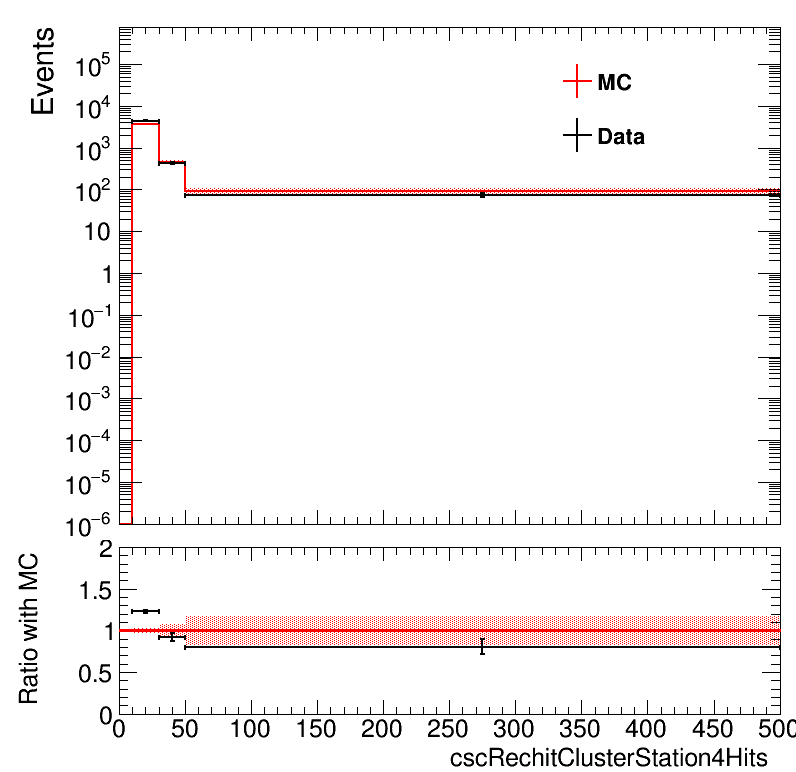

In [8]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.7,0.80,0.95,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
hb = {}
pEff = {}
clusterSize_bins = [0, 10, 20, 30, 40, 50, 60, 70]
# if rechit_cut[sig_ver]< 70: clusterSize_bins += [70]
clusterSize_bins += [100, 150, 250, 500]
var = [cscRechitClusterEta, cscRechitClusterNStation10, cscRechitClusterAvgStation10, cscRechitClusterSize, bdt_score, cscRechitClusterStation1Hits, cscRechitClusterStation2Hits, cscRechitClusterStation3Hits, cscRechitClusterStation4Hits]
title = ['cluster #eta', 'N_{station}', 'Avg Station', 'N_{rechits}', 'BDT score','cscRechitClusterStation1Hits','cscRechitClusterStation2Hits','cscRechitClusterStation3Hits','cscRechitClusterStation4Hits']
bins = [[8,1.2,2.0], [5,0,5], [20,0,5],clusterSize_bins, [10,0,1],[0,10,30,50,500], [0,10,30,50,500],[0,10,30,50,500],[0,10,30,50,500]]
names = [ 'cscRechitClusterEta', 'cscRechitClusterNStation10', 'cscRechitClusterAvgStation10', 'cscRechitClusterSize', 'bdtScore','cscRechitClusterStation1Hits','cscRechitClusterStation2Hits','cscRechitClusterStation3Hits','cscRechitClusterStation4Hits']

ratio = [[0,1.5], [0.5, 2], [0.5, 2], [0.5, 1.5], [0.5, 1.5], [0.5, 1.5],[0.5,1.5],[0.5,1.5],[0.5,1.5]]
ratio_Nrechits130 = [[0.0,2.0], [0.5,1.5], [0.0,2.0], [0.0,1.5], [0,1.5], [0.5, 2], [0.0, 3], [0.5, 1.5], [0.0, 2.0]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

# dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year'+year+\
# '_norm'+str(norm)+'_'+ver+sig_ver
# dir_name += '/'
# if not os.path.isdir(dir_name):os.makedirs(dir_name)
# outputFileName = dir_name +"efficiency_"+'Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.root'
# print(outputFileName)
# outFile = rt.TFile(outputFileName, 'RECREATE')


for j in range(len(bins)):
    if not j == 8: continue
    print(bins[j])
    for i, k in enumerate(['data','mc']):
#         if k == 'data':continue
        total_weight = weight[k+'_nom']
        hm[k] = create_TH1D(np.abs(var[j][k+'_nom']), 'hm1', axis_title = [title[j],'Cluster Efficiency'], binning=bins[j], weights = weight[k+'_nom'])
        print(k,np.sum(total_weight)/np.sum(weight[k+'_denom']*pileupWeight[k+'_denom']))


        total_weight = weight[k+'_denom']
        print(k,np.sum(total_weight[cscRechitClusterStation2Hits[k+"_denom"]>=50])/np.sum(total_weight))
        print(k,np.sum(total_weight[cscRechitClusterSize[k+"_denom"]>=70])/np.sum(total_weight))



        hb[k] = create_TH1D(np.abs(var[j][k+'_denom']), 'hb1', axis_title = [title[j],'Events'], binning=bins[j], weights = weight[k+'_denom'])
        pEff[k] = rt.TEfficiency(hm[k],hb[k])
        hb[k].SetLineColor(std_color_list[i])
        hm[k].SetLineColor(std_color_list[i])
        pEff[k].SetLineColor(std_color_list[i])
        pEff[k].SetLineWidth(2)


#         hm[k].Scale(1.0/hm[k].Integral())
#         hb[k].Scale(1.0/hb[k].Integral())
#         print(k, np.sum(total_weight[var[3][k+'_denom']>=50])/np.sum(total_weight))
#         print(hm[k].Integral()/ hb[k].Integral())
    c = make_ratio_plot([hb['mc'],hb['data']], fit = False, logy=True, in_tags = ["MC","Data"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
#     c = make_ratio_plot([hm['mc'],hm['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
#     c = make_ratio_pEff([pEff['mc'],pEff['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 




#     c = make_ratio_pEff([pEff['mc'],pEff['data']], fit = False, logy=False, in_tags = ["MC","Data"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
#     c.SetLogy()
#     leg.Draw()
    c.Draw()
#     c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
#     c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')

#     c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
#     c.Draw()
#     c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
#     c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
#         #################
#         # apply Nrechits >= 130
#         #################
#         for i, k in enumerate(cond.keys()):
#             total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
#             cut = cscRechitClusterSize[k] >= 130
#             hm[k] = create_TH1D(np.abs(var[j][k][cut]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][cut])
#             hm[k].SetLineColor(std_color_list[i])
#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.C')

#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.C')
# outFile.Close()




